Transformed Sectiontion Method
- "Its core principle involves conceptually converting the multi-material cross-section of a layered beam into an equivalent, fictitious cross-section composed entirely of a single, homogeneous material."
- "The transformation is achieved by adjusting the width of each material by a factor equal to its modular ratio (n_i = E_i / E_ref), relative to the chosen base material."

(hand hardness, grain form) -> density
density -> Youngs Modulus
(Young's Modulus, thickness, orientation) -> Bending stiffness

oal: Violin plots of the following data

Y-axis (1 plot for each variable): Weight, Bending Stiffness (D11) above "weak layer"
    Weak Layer is: 
    - Failure layer of test (ECT, PST)
    - failure layer of avalanche (Crown, flank)
    - or identified layer of concern (Layer of concern)

X-axis: Different groups of pits
    - ECTP
    - ECTN
    - PST < 0.5
    - Pits on crowns
    - Pits on flanks
    - Layer of concern


Larger dataset
- Last five snow years


Need to code

Weight
- Density from hand hardness and grain form
- Weight above weak layer (from layer densities and thickensses)

Bending stiffness
- Elastic modulus (p 1481)
    

In [61]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from snowpylot import caaml_parser


## Outline Transformed Section Method

**Layer Properties**

    rho_i: density of layer i, kg/m^3
    b_i=1: width of layer i, m (start with 1m as baseline)
    h_i: # thickness of layer i

**Calculation**

1. Calculate density from hand hardness and grain form

2. Calculate Young's Modulus from density

    **rho_0** = 917 # kg/m^3 (density of ice), from "A Closed form model..."

    **E_i**= 6.5e3 *(rho_i)**4.4 # From Gerling et al. (2017)

3. Select Reference Material in Slab (highest E)

    **E_ref** = max(E_i) # Choose material with highest E

4. Calculate modular ratio for each layer

    **n_i** = E_i / E_ref

5. Calculate transformed width of each layer

    **b_i_prime** = b_i * n_i # m (transformed width of layer i)

6. Calculate transformed area of each layer

    **A_i_prime** = b_i_prime * h_i # m^2 (transformed area of layer i)

7.  Locate Centroid of Layer

    **y_i** = sum of thickness of layers below i + h_i/2

8.  Locate Centroid of Transformed slab

    **Y_bar** = sum(A_i_prime * y_i) / sum(A_i_prime) # m (centroid of transformed slab)

9.  Calculate Moment of Inertia (I) of the Transformed Slab

    **I_i** = (1/12) * b_i_prime * h_i**3 # m^4 (moment of inertia of layer i)

    **d_i** = abs(y_i-Y_bar) # m (distance from centroid of layer i to centroid of transformed slab)

    **I_bar** = sum(I_i + A_i_prime * d_i**2) # m^4 (moment of inertia of transformed slab) NOTE: CHECK THIS EQUATION

10. Calculate Equivalent Bending Stiffness (D11) of the Transformed Slab

    **D11** = E_ref * I_bar # N*m^2 (bending stiffness of transformed slab)


parse_pits function: Parses all pits in a specified folder

In [62]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """

    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = folder_path + "/" + file  # create the file path
        pit = caaml_parser(file_path)  # parse the file
        pits_list.append(pit)

    return pits_list


Specify folders for 2020-2024 Water Years and parse files

In [63]:
# Define folders and parse pits

pits_19_20 = parse_pits("../snowpits/by_season/2019-2020")
pits_20_21 = parse_pits("../snowpits/by_season/2020-2021")
pits_21_22 = parse_pits("../snowpits/by_season/2021-2022")
pits_22_23 = parse_pits("../snowpits/by_season/2022-2023")
pits_23_24 = parse_pits("../snowpits/by_season/2023-2024")

all_pits = (
    pits_19_20 + pits_20_21 + pits_21_22 + pits_22_23 + pits_23_24
)  # list of all pits


Geldsetzer table of density from hand hardness and grain form

In [64]:
geldsetzer_df = pd.read_csv('geldsetzer_table.csv', index_col=0)

def get_density(hand_hardness, grain_form, df=geldsetzer_df):
    """
    Get density value for a specific hand hardness and grain form combination.
    
    Parameters:
    df (pd.DataFrame): The Geldsetzer table DataFrame
    hand_hardness (str): Hand hardness value (e.g., 'F-', '4F+', 'P-', etc.)
    grain_form (str): Grain form (e.g., 'PP', 'DF', 'RG', 'FC', 'DH', etc.)
    
    Returns:
    float: Density value, or NaN if not available
    """
    try:
        return df.loc[hand_hardness, grain_form]
    except KeyError:
        return np.nan

def convert_grain_form(layer):
    """
    Convert grain form to code needed for Geldsetzer table.
    
    Parameters:
    layer: Snow layer object with grain_form_primary attribute
    
    Returns:
    str: Grain form code for Geldsetzer table lookup
    """
    if layer.grain_form_primary.sub_grain_class_code in ["PPgp","RGmx","FCmx"]:
        return layer.grain_form_primary.sub_grain_class_code
    else:
        return layer.grain_form_primary.basic_grain_class_code


In [65]:
def calculate_weight_above_layer(layers, target_layer):
    """
    Calculate cumulative weight above a specified target layer (excludes target layer).

    Parameters:
    layers: List of snow layer objects
    target_layer: The layer to stop calculation at (weight calculated above this layer)
    
    Returns:
    float: Weight above target layer in kg/m², or NaN if calculation fails
    """
    weight_above = 0
    target_found = False
    
    for layer in layers:
        # Check if we've reached the target layer - if so, stop BEFORE including it
        if layer is target_layer:
            target_found = True
            break
            
        # Convert grain form to code needed for Geldsetzer table
        grain_form = convert_grain_form(layer)
        
        # Get density
        density = get_density(layer.hardness, grain_form)
        
        if pd.isna(density):
            return np.nan
            
        # Calculate weight
        thickness_m = (layer.thickness[0])/100  # convert cm to m
        weight = thickness_m * density  # Weight in kg (assuming 1 m^2 cross-section)
        weight_above += weight
    
    # If target layer was not found, return NaN
    if not target_found:
        return np.nan
        
    return weight_above


In [66]:
def calculate_bending_stiffness(layers, target_layer):
    """
    Calculate bending stiffness above a specified target layer using the Transformed Section Method.
    
    Parameters:
    layers: List of snow layer objects
    target_layer: The layer to stop calculation at (bending stiffness calculated for slab above this layer)
    
    Returns:
    float: Bending stiffness (D11) in N*m^2, or NaN if calculation fails
    """
    
    # Collect layer properties for layers above the target layer
    layer_properties = []
    target_found = False
    
    for layer in layers:
        # Check if we've reached the target layer - if so, stop BEFORE including it
        if layer is target_layer:
            target_found = True
            break
            
        # Convert grain form to code needed for Geldsetzer table
        grain_form = convert_grain_form(layer)
        
        # Get density
        density = get_density(layer.hardness, grain_form)
        
        if pd.isna(density):
            return np.nan
            
        # Calculate layer properties
        thickness_m = (layer.thickness[0])/100  # convert cm to m
        
        # Step 2: Calculate Young's Modulus from density
        E_i = 6.5e3 * (density**4.4)  # From Gerling et al. (2017)
        
        # Store layer properties
        layer_properties.append({
            'density': density,
            'thickness': thickness_m,
            'E_i': E_i,
            'b_i': 1.0  # width of layer i, m (baseline = 1m)
        })
    
    # If target layer was not found or no layers above it, return NaN
    if not target_found or len(layer_properties) == 0:
        return np.nan
    
    # Step 3: Select Reference Material in Slab (highest E)
    E_ref = max(layer_prop['E_i'] for layer_prop in layer_properties)
    
    # Steps 4-6: Calculate modular ratio, transformed width, and transformed area
    for layer_prop in layer_properties:
        layer_prop['n_i'] = layer_prop['E_i'] / E_ref  # modular ratio
        layer_prop['b_i_prime'] = layer_prop['b_i'] * layer_prop['n_i']  # transformed width
        layer_prop['A_i_prime'] = layer_prop['b_i_prime'] * layer_prop['thickness']  # transformed area
    
    # Step 7: Locate Centroid of each Layer
    for i, layer_prop in enumerate(layer_properties):
        # y_i = sum of thickness of layers below i + h_i/2
        # Note: layers list is from top to bottom, so "below" means higher index
        thickness_below = sum(layer_properties[j]['thickness'] for j in range(i+1, len(layer_properties)))
        layer_prop['y_i'] = thickness_below + layer_prop['thickness']/2
    
    # Step 8: Locate Centroid of Transformed Slab
    numerator = sum(layer_prop['A_i_prime'] * layer_prop['y_i'] for layer_prop in layer_properties)
    denominator = sum(layer_prop['A_i_prime'] for layer_prop in layer_properties)
    
    if denominator == 0:
        return np.nan
        
    Y_bar = numerator / denominator  # centroid of transformed slab
    
    # Step 9: Calculate Moment of Inertia (I) of the Transformed Slab
    I_bar = 0
    for layer_prop in layer_properties:
        # Moment of inertia of layer i about its own centroid
        I_i = (1/12) * layer_prop['b_i_prime'] * (layer_prop['thickness']**3)
        
        # Distance from centroid of layer i to centroid of transformed slab
        d_i = abs(layer_prop['y_i'] - Y_bar)
        
        # Parallel axis theorem: I = I_local + A * d^2
        I_bar += I_i + layer_prop['A_i_prime'] * (d_i**2)
    
    # Step 10: Calculate Equivalent Bending Stiffness (D11) of the Transformed Slab
    D11 = E_ref * I_bar  # N*m^2 (bending stiffness of transformed slab)
    
    return D11


In [67]:
def filter_pits_with_hardness_and_grain_form(pits):
    """
    Filter pits to only include those with complete hardness and grain form data.
    
    Parameters:
    pits: List of pit objects
    
    Returns:
    list: Filtered list of pits with complete data
    """
    filtered_pits = []
    
    for pit in pits:
        all_layers_info = True
        layers = pit.snow_profile.layers
        for layer in layers:
            if layer.hardness is None or layer.grain_form_primary is None:
                all_layers_info = False
                break
        if all_layers_info:
            filtered_pits.append(pit)
            
    return filtered_pits

def filter_pits_with_layer_of_concern(pits):
    """
    Filter pits to only include those with at least one layer of concern.
    
    Parameters:
    pits: List of pit objects
    
    Returns:
    list: Filtered list of pits with layer of concern
    """
    filtered_pits = []
    
    for pit in pits:
        layers = pit.snow_profile.layers
        has_loc = any(layer.layer_of_concern for layer in layers)
        if has_loc:
            filtered_pits.append(pit)
            
    return filtered_pits

def filter_pits_with_ECTP_propagation(pits):
    """
    Filter pits with ECTP results
    
    Parameters:
    pits: List of pit objects

    Returns:
    list: Filtered list of pits with ECTP results
    """
    filtered_pits = []
    
    for pit in pits:
        ECTs_list = pit.stability_tests.ECT  # list of ECTs for pit
        for ECT in ECTs_list:
            if ECT.propagation:
                filtered_pits.append(pit)
                break
    return filtered_pits

def filter_pits_by_location(pits, location_type):
    """
    Filter pits by avalanche location type (crown or flank).
    
    Parameters:
    pits: List of pit objects
    location_type: String, either "crown" or "flank"
    
    Returns:
    list: Filtered list of pits at specified location
    """
    filtered_pits = []
    
    for pit in pits:
        if pit.core_info.location.pit_near_avalanche_location == location_type:
            filtered_pits.append(pit)
            
    return filtered_pits


In [68]:
def find_layer_of_concern(pit):
    """
    Find the layer of concern in a pit.
    
    Parameters:
    pit: A single pit object
    
    Returns:
    layer: The layer of concern, or None if not found
    """
    layers = pit.snow_profile.layers
    
    # Find the layer of concern
    for layer in layers:
        if layer.layer_of_concern:
            return layer
            
    return None

def find_ECTP_propagation_layer(pit):
    """
    Find the ECTP propagation layer in a pit.
    
    Parameters:
    pit: A single pit object
    
    Returns:
    layer: The ECTP propagation layer, or None if not found
    """
    ECTs_list = pit.stability_tests.ECT  # list of ECTs for pit
    layers = pit.snow_profile.layers  # List of layers in pit
    
    for ECT in ECTs_list:  # For each ECT in pit
        if ECT.propagation:  # If ECTP
            prop_layer_depth_top = ECT.depth_top  # depth of top of propagation layer 
            
            # Find the layer of propagation in layers
            for layer in layers:
                if layer.depth_top == prop_layer_depth_top:
                    return layer
                    
    return None


In [69]:
def create_pit_analysis_dataframe(pits, layer_finder_function=find_layer_of_concern):
    """
    Create a dataframe with snowpit analysis data for any list of pit objects.
    
    Parameters:
    pits: List of pit objects to analyze
    layer_finder_function: Function that takes a pit and returns the target layer 
                          (default: find_layer_of_concern)
    include_additional_data: Boolean, whether to include additional pit metadata
                           (default: False)
    
    Returns:
    pd.DataFrame: DataFrame with snowpit analysis results
    """
    data_rows = []
    
    for pit in pits:
        # Find the target layer for this pit using the provided function
        target_layer = layer_finder_function(pit)
        
        if target_layer is not None:
            # Calculate weight above the target layer
            weight_above = calculate_weight_above_layer(pit.snow_profile.layers, target_layer)
            
            # Calculate bending stiffness above the target layer
            bending_stiffness = calculate_bending_stiffness(pit.snow_profile.layers, target_layer)
            
            # Create basic row for dataframe
            row = {
                'snowpit_id': pit.core_info.pit_id,
                'weight_above_target_layer': weight_above,
                'bending_stiffness_above_target_layer': bending_stiffness
            }
            
            data_rows.append(row)
    
    # Create DataFrame
    df_results = pd.DataFrame(data_rows)
    
    return df_results


## Find Pits with Hand Hardness and Grain Form



In [70]:
## Set up datasets

# Total
print("Total Pits: ", len(all_pits))

# Pits with hand hardness and grain form
pits_with_hardness_and_grain_form = filter_pits_with_hardness_and_grain_form(all_pits)
print("Pits with hand hardness and grain form: ", len(pits_with_hardness_and_grain_form))

# Pits with indicated layer of concern
pits_with_layer_of_concern = filter_pits_with_layer_of_concern(pits_with_hardness_and_grain_form)
print("Pits with hand hardness and grain form, and layer of concern: ", len(pits_with_layer_of_concern))

# Pits with ECTP propagation layer
pits_with_ECTP_propagation_layer = filter_pits_with_ECTP_propagation(pits_with_layer_of_concern)
print("Pits with hand hardness and grain form, and ECTP propagation layer: ", len(pits_with_ECTP_propagation_layer))

# Pits on Crowns with layer of concern
pits_on_crowns_with_layer_of_concern = filter_pits_by_location(pits_with_layer_of_concern, "crown")
print("Pits on Crowns with layer of concern: ", len(pits_on_crowns_with_layer_of_concern))

# Pits on Flanks with layer of concern
pits_on_flanks_with_layer_of_concern = filter_pits_by_location(pits_with_layer_of_concern, "flank")
print("Pits on Flanks with layer of concern: ", len(pits_on_flanks_with_layer_of_concern))

# NOTE: Totals do not account for pits with layers that do not work with Geldsetzer table


Total Pits:  31170
Pits with hand hardness and grain form:  12466
Pits with hand hardness and grain form, and layer of concern:  9316
Pits with hand hardness and grain form, and ECTP propagation layer:  2692
Pits on Crowns with layer of concern:  172
Pits on Flanks with layer of concern:  80


### Build Results DFs

In [71]:
# Create dataframe with snowpit data, weight above layer of concern, and bending stiffness
all_LOC_results_df = create_pit_analysis_dataframe(pits_with_layer_of_concern, 
                                          layer_finder_function=find_layer_of_concern)

crown_LOC_results_df = create_pit_analysis_dataframe(pits_on_crowns_with_layer_of_concern, 
                                          layer_finder_function=find_layer_of_concern)

flank_LOC_results_df = create_pit_analysis_dataframe(pits_on_flanks_with_layer_of_concern, 
                                          layer_finder_function=find_layer_of_concern)

ECTP_results_df = create_pit_analysis_dataframe(pits_with_ECTP_propagation_layer, 
                                          layer_finder_function=find_ECTP_propagation_layer)


In [72]:
# Create combined dataframe with all results
combined_data = []

# Add data from each dataset with appropriate labels
if len(all_LOC_results_df) > 0:
    df_temp = all_LOC_results_df.copy()
    df_temp['dataset'] = 'All Layer of Concern'
    combined_data.append(df_temp[['snowpit_id', 'weight_above_target_layer', 'bending_stiffness_above_target_layer', 'dataset']].dropna())

if len(crown_LOC_results_df) > 0:
    df_temp = crown_LOC_results_df.copy()
    df_temp['dataset'] = 'Crown Pits'
    combined_data.append(df_temp[['snowpit_id', 'weight_above_target_layer', 'bending_stiffness_above_target_layer', 'dataset']].dropna())

if len(flank_LOC_results_df) > 0:
    df_temp = flank_LOC_results_df.copy()
    df_temp['dataset'] = 'Flank Pits'
    combined_data.append(df_temp[['snowpit_id', 'weight_above_target_layer', 'bending_stiffness_above_target_layer', 'dataset']].dropna())

if len(ECTP_results_df) > 0:
    df_temp = ECTP_results_df.copy()
    df_temp['dataset'] = 'ECTP Propagation'
    combined_data.append(df_temp[['snowpit_id', 'weight_above_target_layer', 'bending_stiffness_above_target_layer', 'dataset']].dropna())

# Combine all data
if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # Display info about the combined dataframe
    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Columns: {list(combined_df.columns)}")
    print("\nDataset counts:")
    print(combined_df['dataset'].value_counts())
    
    # Save to CSV
    #combined_df.to_csv("combined_df.csv", index=False)
    #print("\nCombined dataframe saved to 'combined_df.csv'")
else:
    print("No data available for combining. Please run the previous cells to generate the datasets.")


Combined dataframe shape: (6019, 4)
Columns: ['snowpit_id', 'weight_above_target_layer', 'bending_stiffness_above_target_layer', 'dataset']

Dataset counts:
dataset
All Layer of Concern    4815
ECTP Propagation        1046
Crown Pits               114
Flank Pits                44
Name: count, dtype: int64


### Plot and Analyze results

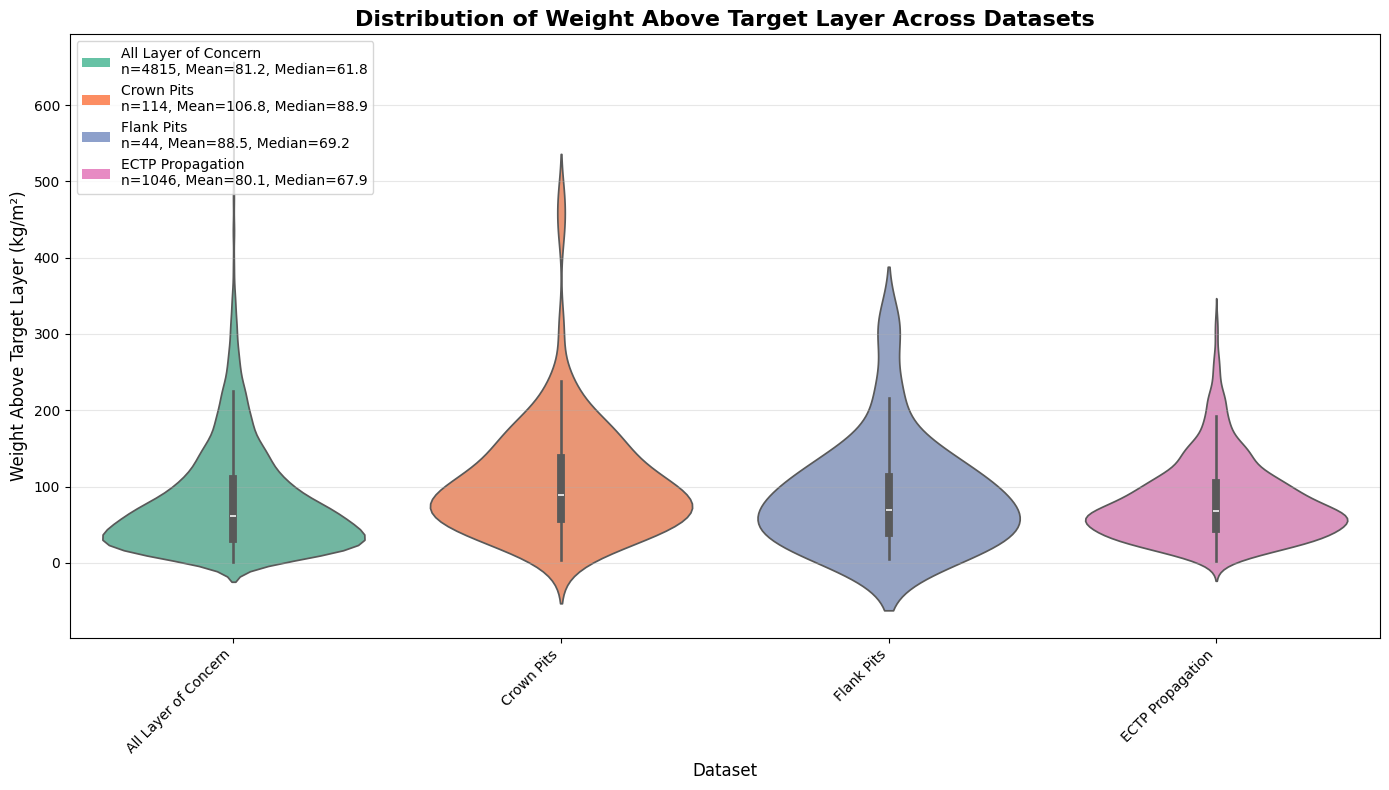

In [77]:
# Distribution of Weight Above Weak Layers for Each Dataset

# Create violin plot
plt.figure(figsize=(14, 8))
ax = sns.violinplot(data=combined_df, x='dataset', y='weight_above_target_layer', 
                   hue='dataset', inner='box', palette='Set2', legend=False)

# Calculate statistics and create custom legend
from matplotlib.patches import Patch
legend_elements = []
datasets = combined_df['dataset'].unique()
colors = sns.color_palette('Set2', len(datasets))

for i, dataset in enumerate(datasets):
    data_subset = combined_df[combined_df['dataset'] == dataset]['weight_above_target_layer']
    n = len(data_subset)
    mean = data_subset.mean()
    median = data_subset.median()
    
    # Create legend entry with colored patch
    legend_elements.append(Patch(facecolor=colors[i], 
                                label=f'{dataset}\nn={n}, Mean={mean:.1f}, Median={median:.1f}'))

# Customize the plot
plt.title('Distribution of Weight Above Target Layer Across Datasets', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Weight Above Target Layer (kg/m²)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add custom legend
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()



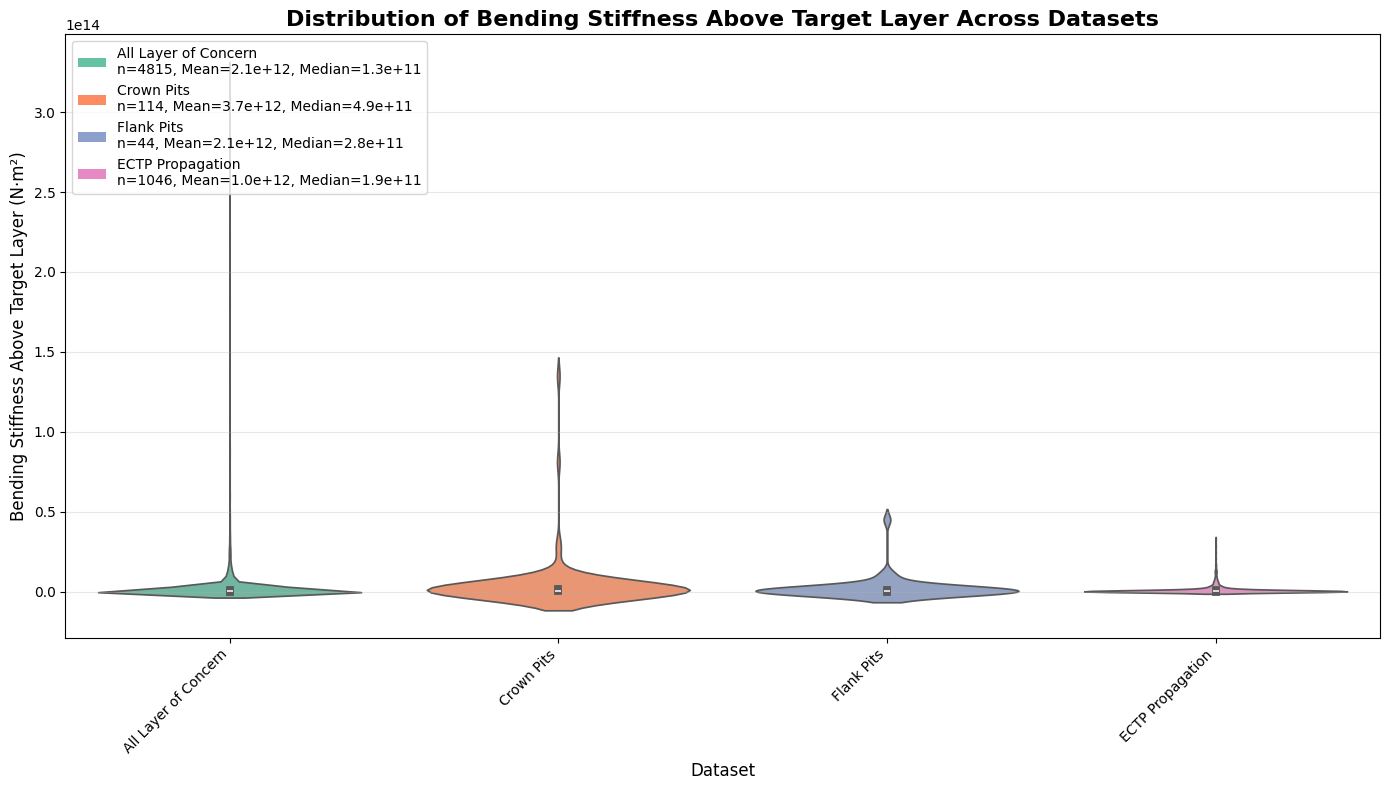

In [78]:
# Distribution of Bending Stiffness of Slab above Weak Layers for Each Dataset

# Create violin plot
plt.figure(figsize=(14, 8))
ax = sns.violinplot(data=combined_df, x='dataset', y='bending_stiffness_above_target_layer', 
                   hue='dataset', inner='box', palette='Set2', legend=False)

# Calculate statistics and create custom legend
from matplotlib.patches import Patch
legend_elements = []
datasets = combined_df['dataset'].unique()
colors = sns.color_palette('Set2', len(datasets))

for i, dataset in enumerate(datasets):
    data_subset = combined_df[combined_df['dataset'] == dataset]['bending_stiffness_above_target_layer']
    n = len(data_subset)
    mean = data_subset.mean()
    median = data_subset.median()
    
    # Create legend entry with colored patch
    legend_elements.append(Patch(facecolor=colors[i], 
                                label=f'{dataset}\nn={n}, Mean={mean:.1e}, Median={median:.1e}'))

# Customize the plot
plt.title('Distribution of Bending Stiffness Above Target Layer Across Datasets', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Bending Stiffness Above Target Layer (N·m²)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add custom legend
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


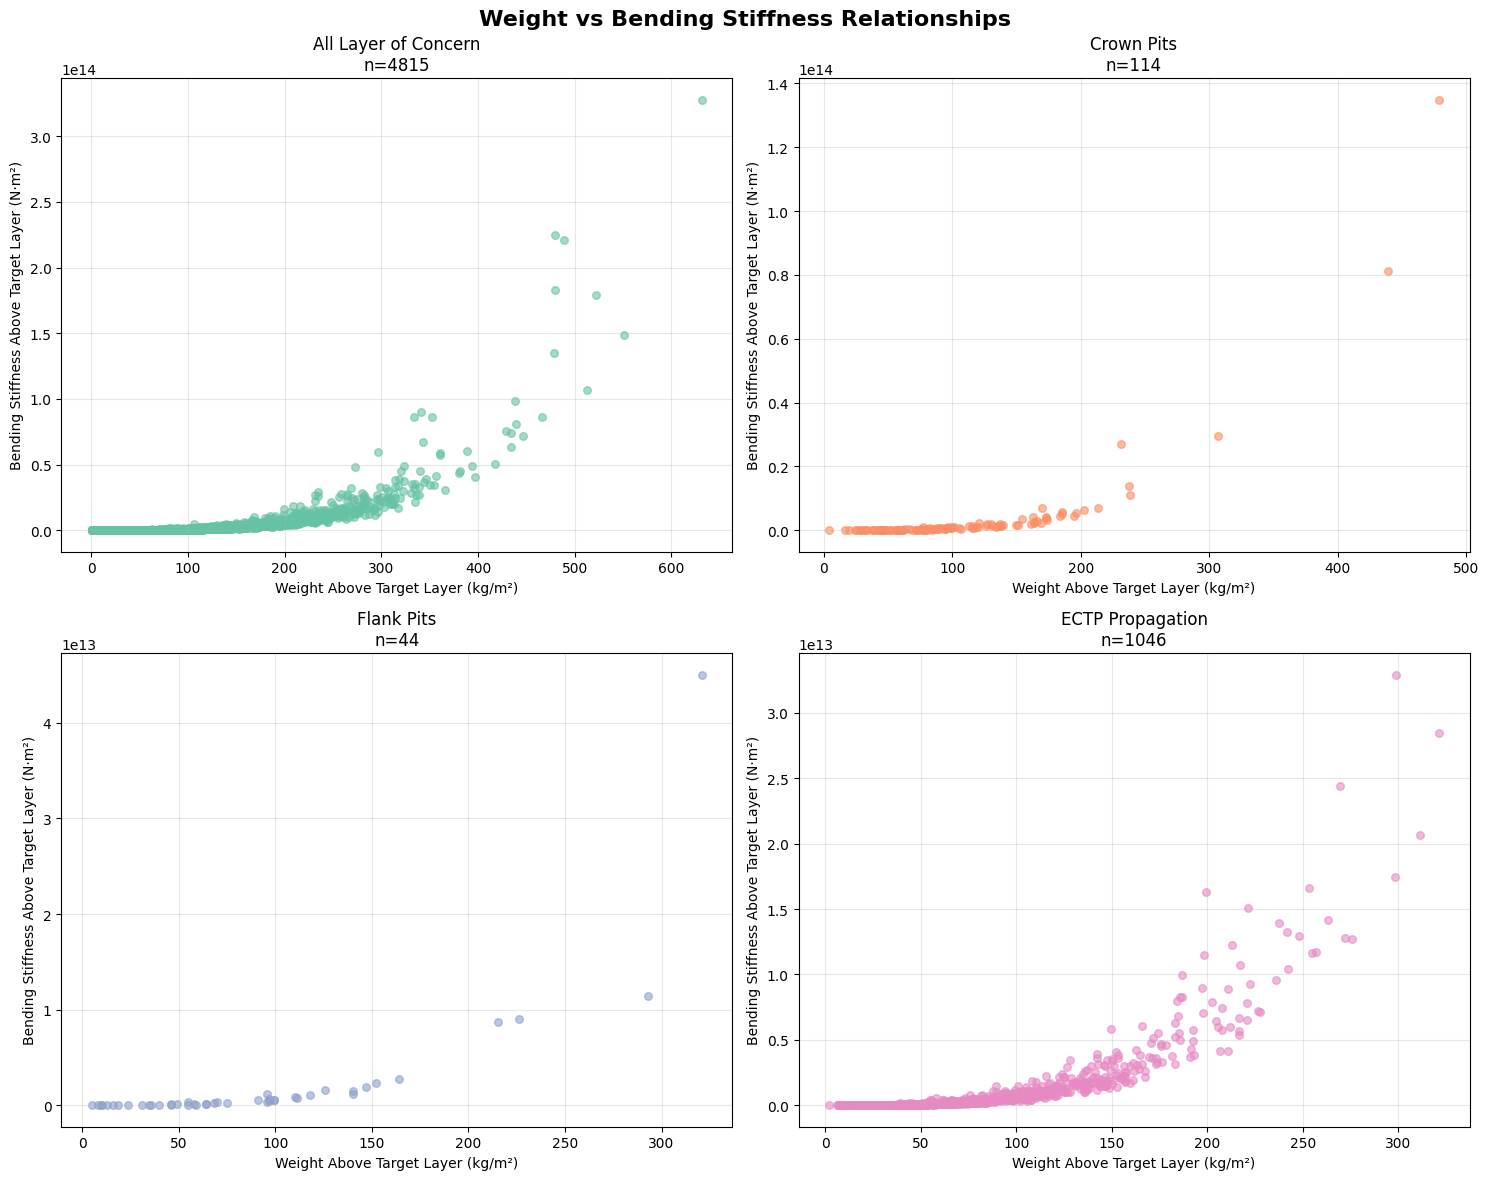

In [80]:
# Weight vs Bending Stiffness Scatterplots

# Create subplots for each dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Weight vs Bending Stiffness Relationships', fontsize=16, fontweight='bold')

datasets = ['All Layer of Concern', 'Crown Pits', 'Flank Pits', 'ECTP Propagation']
colors = sns.color_palette('Set2', len(datasets))

for i, (dataset, color) in enumerate(zip(datasets, colors)):
    # Select subplot
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Filter data for this dataset
    data_subset = combined_df[combined_df['dataset'] == dataset].copy()
    
    if len(data_subset) > 0:
        # Create scatterplot
        ax.scatter(data_subset['weight_above_target_layer'], 
                  data_subset['bending_stiffness_above_target_layer'], 
                  alpha=0.6, color=color, s=30)
        
        # Add sample size to title
        valid_data = data_subset[['weight_above_target_layer', 'bending_stiffness_above_target_layer']].dropna()
        ax.set_title(f'{dataset}\nn={len(valid_data)}', fontsize=12)
        
        # Format axes
        ax.set_xlabel('Weight Above Target Layer (kg/m²)', fontsize=10)
        ax.set_ylabel('Bending Stiffness Above Target Layer (N·m²)', fontsize=10)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        ax.grid(True, alpha=0.3)
    else:
        ax.set_title(f'{dataset}\nNo data available', fontsize=12)
        ax.set_xlabel('Weight Above Target Layer (kg/m²)', fontsize=10)
        ax.set_ylabel('Bending Stiffness Above Target Layer (N·m²)', fontsize=10)

plt.tight_layout()
plt.show()
